In [1]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import pickle
import os
import gc

import multiprocessing
import random
import time

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from bayes_opt import BayesianOptimization
from sm_utils import sampling, evaluate, save_model, load_model, make_train_data,  make_test_data

/home/dmig/py_libs/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

In [8]:
RESULT_PATH = '/home/dmig/work/upsell/result/summary'

## Load data

In [57]:
df_mart06 = pd.read_pickle('/home/dmig/work/upsell/data/df_input_201906.pkl')

df_mart06.shape

(18855464, 80)

In [58]:
df_base_mart06 = df_mart06.copy()

In [3]:
df_mart05 = pd.read_pickle('/home/dmig/work/upsell/data/df_mart_201905.pkl')

df_mart05.shape

(18707537, 81)

In [4]:
feature_cols = [c for c in df_mart06.columns if c != 'svc_mgmt_num']

## Feature Engineering

In [5]:
from functools import reduce

def merge_df(df_mart, ym):
    
    df_tmp = df_mart[['svc_mgmt_num', 'avg_subscription_period']]
    
    avg_sub = pd.read_pickle(os.path.join(DATA_PATH, 'avg_subscription_period_{}.pkl'.format(ym)))
    fee_chg_cnt = pd.read_pickle(os.path.join(DATA_PATH, 'fee_chg_cnt_{}.pkl'.format(ym)))
    fee_chg_period = pd.read_pickle(os.path.join(DATA_PATH, 'fee_chg_period_{}.pkl'.format(ym)))
    new_avg = pd.read_pickle(os.path.join(DATA_PATH, 'new_avg_{}.pkl'.format(ym)))
    
    print('avg_sub: ', avg_sub.shape)
    print('fee_chg_cnt: ', fee_chg_cnt.shape)
    print('fee_chg_period: ', fee_chg_period.shape)
    print('new_avg: ', new_avg.shape)
    
    avg_sub.columns = ['svc_mgmt_num', 'fixed_avg_subsription_period']
    fee_chg_cnt.columns = ['svc_mgmt_num', 'fee_chg_cnt']
    fee_chg_period.columns = ['svc_mgmt_num', 'fee_chg_period']
    new_avg.columns = ['svc_mgmt_num', 'new_avg_subsription_period']
    
    df_list = [df_tmp, avg_sub, fee_chg_cnt, new_avg, fee_chg_period]
    
    t1 = time.time()
    df_merged = reduce(lambda left, right: pd.merge(left, right, on=['svc_mgmt_num'], how='left'), df_list)
    print('elapsed time:', time.time()-t1)
    
    return df_merged

In [59]:
df_merged06 = merge_df(df_mart06, '06')

avg_sub:  (19340846, 2)
fee_chg_cnt:  (19340846, 2)
fee_chg_period:  (30649469, 2)
new_avg:  (19336877, 2)
elapsed time: 151.46546745300293


In [9]:
df_merged05 = merge_df(df_mart05, '05')
df_merged06 = merge_df(df_mart06, '06')

df_merged05.shape, df_merged06.shape

avg_sub:  (19306174, 2)
fee_chg_cnt:  (19306174, 2)
fee_chg_period:  (30313644, 2)
new_avg:  (19306174, 2)
elapsed time: 194.8159852027893
avg_sub:  (19340846, 2)
fee_chg_cnt:  (19340846, 2)
fee_chg_period:  (30649469, 2)
new_avg:  (19336877, 2)
elapsed time: 170.8725769519806


((18707537, 6), (18855464, 6))

In [60]:
# df_mart05['avg_subscription_period'] = df_merged05['fixed_avg_subsription_period']
# df_mart05['fee_chg_cnt'] = df_merged05['fee_chg_cnt']
# df_mart05['new_avg_subsription_period'] = df_merged05['new_avg_subsription_period']
# df_mart05['fee_chg_period'] = df_merged05['fee_chg_period']

df_mart06['avg_subscription_period'] = df_merged06['fixed_avg_subsription_period']
df_mart06['fee_chg_cnt'] = df_merged06['fee_chg_cnt']
df_mart06['new_avg_subsription_period'] = df_merged06['new_avg_subsription_period']
df_mart06['fee_chg_period'] = df_merged06['fee_chg_period']

In [11]:
total_feature_cols = feature_cols + ['fee_chg_cnt', 'new_avg_subsription_period', 'fee_chg_period']

## Load model

In [12]:
clf = load_model('/home/dmig/work/upsell/model/update_model0729.pkl')
clf

load model from  /home/dmig/work/upsell/model/update_model0729.pkl


In [48]:
base_clf = load_model('/home/dmig/work/upsell/model/final_model.pkl')

load model from  /home/dmig/work/upsell/model/final_model.pkl


In [105]:
new_clf = load_model('/home/dmig/work/upsell/model/parameter_tuning_model0731.pkl')

load model from  /home/dmig/work/upsell/model/parameter_tuning_model0731.pkl


## Score

In [75]:
df_mart06['score'] = clf.predict(df_mart06[total_feature_cols])

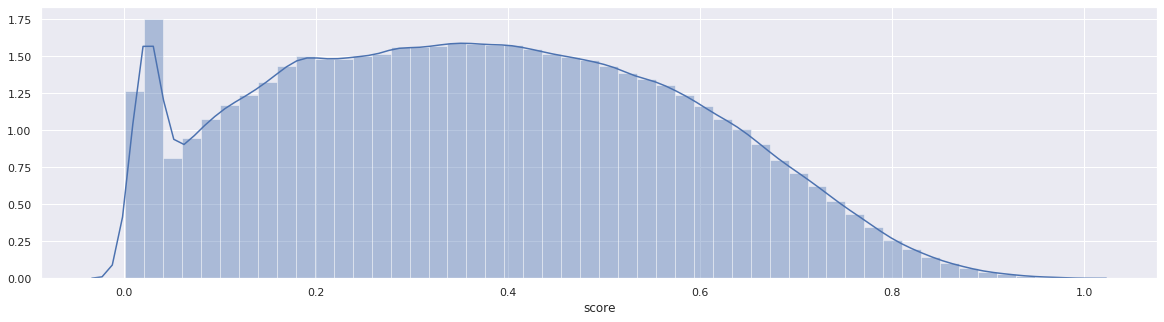

In [31]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_mart06.sample(frac=0.1)['score'])

#### tuning model

In [106]:
df_mart06['new_score'] = new_clf.predict(df_mart06[total_feature_cols])

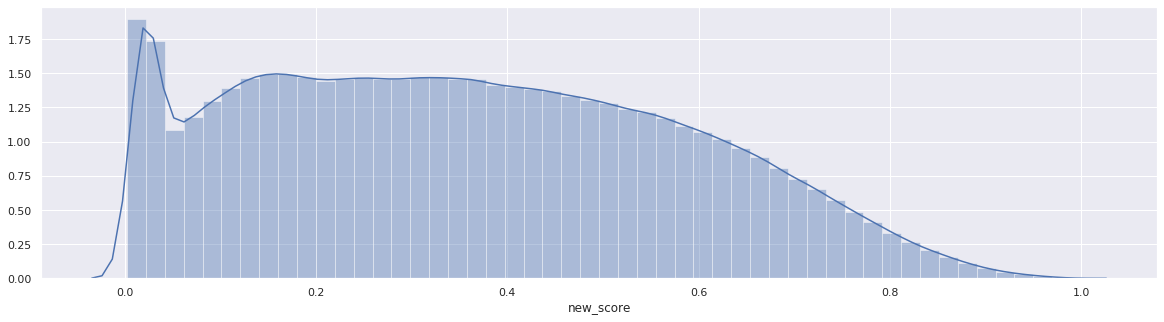

In [107]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_mart06.sample(frac=0.1)['new_score'])

In [40]:
target = '7300818751'

clf.predict(df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])

array([0.19013868])

## Shap values

In [16]:
import shap
explainer = shap.TreeExplainer(clf)

In [49]:
base_explainer = shap.TreeExplainer(base_clf)

In [108]:
new_explainer = shap.TreeExplainer(new_clf)

## KANBAN error case

#### 1. 데이터 소진율이 적은 고객

In [109]:
target = '7300818751'
print('기존 score: ', base_clf.predict(df_base_mart06[df_base_mart06['svc_mgmt_num']==target][feature_cols])[0])
print('새 모델 score: ', clf.predict(df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])[0])
print('튜닝 모델 score: ', new_clf.predict(df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])[0])

기존 score:  0.6983034427336661
새 모델 score:  0.19013867943675558
튜닝 모델 score:  0.1675817052284174


In [63]:
shap_values = explainer.shap_values(df_mart06[df_base_mart06['svc_mgmt_num']== target][total_feature_cols])
base_shap_values = base_explainer.shap_values(df_base_mart06[df_mart06['svc_mgmt_num']== target][feature_cols])

In [65]:
shap.force_plot(base_explainer.expected_value, base_shap_values[0,:],  df_base_mart06[df_base_mart06['svc_mgmt_num']==target][feature_cols])

In [56]:
shap.force_plot(explainer.expected_value, shap_values[0,:],  df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])

In [110]:
shap.force_plot(new_explainer.expected_value, shap_values[0,:],  df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])

In [111]:
target = '7301516452'
print('기존 score: ', base_clf.predict(df_base_mart06[df_base_mart06['svc_mgmt_num']==target][feature_cols])[0])
print('새 모델 score: ', clf.predict(df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])[0])
print('튜닝 모델 score: ', new_clf.predict(df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])[0])

기존 score:  0.8292613337984597
새 모델 score:  0.16312899056574148
튜닝 모델 score:  0.23280816066279977


In [67]:
shap.force_plot(base_explainer.expected_value, base_shap_values[0,:],  df_base_mart06[df_base_mart06['svc_mgmt_num']==target][feature_cols])

In [68]:
shap.force_plot(explainer.expected_value, shap_values[0,:],  df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])

In [112]:
shap.force_plot(new_explainer.expected_value, shap_values[0,:],  df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])

### 2. 심야 데이터 사용

In [113]:
target = '7278902818'
print('기존 score: ', base_clf.predict(df_base_mart06[df_base_mart06['svc_mgmt_num']==target][feature_cols])[0])
print('새 모델 score: ', clf.predict(df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])[0])
print('튜닝 모델 score: ', new_clf.predict(df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])[0])

기존 score:  0.923089016142128
새 모델 score:  0.40592528532748134
튜닝 모델 score:  0.32237211758124884


In [70]:
shap.force_plot(base_explainer.expected_value, base_shap_values[0,:],  df_base_mart06[df_base_mart06['svc_mgmt_num']==target][feature_cols])

In [71]:
shap.force_plot(explainer.expected_value, shap_values[0,:],  df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])

In [114]:
shap.force_plot(new_explainer.expected_value, shap_values[0,:],  df_mart06[df_mart06['svc_mgmt_num']==target][total_feature_cols])

In [79]:
target_list = ['7278902818', '7301516452', '7300818751']

In [76]:
df_score = df_mart06[['svc_mgmt_num', 'score']]

In [78]:
df_score['percent_rk'] = np.round(df_score.score.rank(pct=True, ascending=True), 4)

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
df_score[df_score['svc_mgmt_num'].isin(target_list)]

svc_mgmt_num     score  percent_rk
94069   7301516452  0.163129      0.1946
15920   7278902818  0.405925      0.5663
34378   7300818751  0.190139      0.2341

In [82]:
df_score.head()

svc_mgmt_num     score  percent_rk
0   1000181902  0.222370      0.2819
1   1000249506  0.580152      0.8166
2   1000439203  0.337309      0.4582
3   1000868610  0.089954      0.1046
4   1002110303  0.696227      0.9337

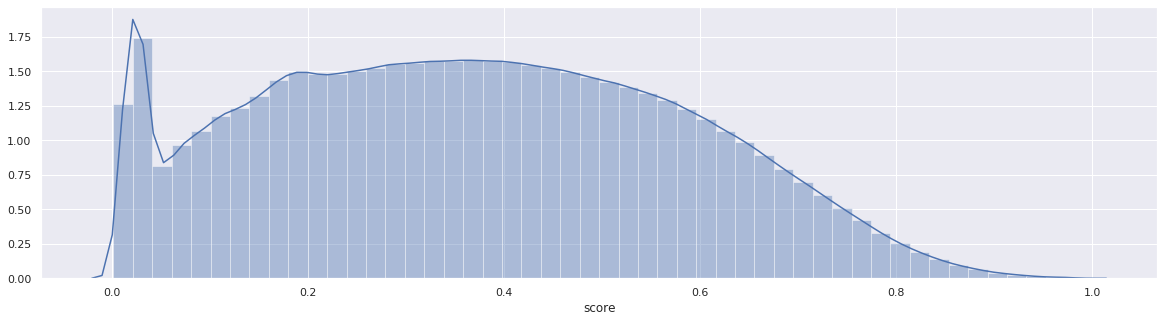

In [83]:
sns.distplot(df_score.score)

## Formatting

In [84]:
df_score['prod_id'] = 'RC00000001'
df_score['prod_nm'] = '요금제업셀가망'
df_score['reco_type'] = 'upsell'
df_score['model'] = 'dominic_lgbm_20190729'
df_score['dt'] = '20190729'

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [85]:
df_score.head()

svc_mgmt_num     score  percent_rk     prod_id  prod_nm reco_type  \
0   1000181902  0.222370      0.2819  RC00000001  요금제업셀가망    upsell   
1   1000249506  0.580152      0.8166  RC00000001  요금제업셀가망    upsell   
2   1000439203  0.337309      0.4582  RC00000001  요금제업셀가망    upsell   
3   1000868610  0.089954      0.1046  RC00000001  요금제업셀가망    upsell   
4   1002110303  0.696227      0.9337  RC00000001  요금제업셀가망    upsell   

                   model        dt  
0  dominic_lgbm_20190729  20190729  
1  dominic_lgbm_20190729  20190729  
2  dominic_lgbm_20190729  20190729  
3  dominic_lgbm_20190729  20190729  
4  dominic_lgbm_20190729  20190729

In [86]:
df_score.drop('percent_rk', axis=1, inplace=True)

/home/dmig/py_libs/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [88]:
df_score.head()

svc_mgmt_num     score     prod_id  prod_nm reco_type  \
0   1000181902  0.222370  RC00000001  요금제업셀가망    upsell   
1   1000249506  0.580152  RC00000001  요금제업셀가망    upsell   
2   1000439203  0.337309  RC00000001  요금제업셀가망    upsell   
3   1000868610  0.089954  RC00000001  요금제업셀가망    upsell   
4   1002110303  0.696227  RC00000001  요금제업셀가망    upsell   

                   model        dt  
0  dominic_lgbm_20190729  20190729  
1  dominic_lgbm_20190729  20190729  
2  dominic_lgbm_20190729  20190729  
3  dominic_lgbm_20190729  20190729  
4  dominic_lgbm_20190729  20190729

In [89]:
df_score.shape

(18855464, 7)

## load to hive

In [90]:
from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive

In [99]:
conn = hive_connection('dmig')

In [92]:
df_score['score'] = np.round(df_score['score'], 4)

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [93]:
df_score.head()

svc_mgmt_num   score     prod_id  prod_nm reco_type                  model  \
0   1000181902  0.2224  RC00000001  요금제업셀가망    upsell  dominic_lgbm_20190729   
1   1000249506  0.5802  RC00000001  요금제업셀가망    upsell  dominic_lgbm_20190729   
2   1000439203  0.3373  RC00000001  요금제업셀가망    upsell  dominic_lgbm_20190729   
3   1000868610  0.0900  RC00000001  요금제업셀가망    upsell  dominic_lgbm_20190729   
4   1002110303  0.6962  RC00000001  요금제업셀가망    upsell  dominic_lgbm_20190729   

         dt  
0  20190729  
1  20190729  
2  20190729  
3  20190729  
4  20190729

In [94]:
df_submit = df_score[['svc_mgmt_num', 'prod_id', 'prod_nm', 'score', 'reco_type', 'model', 'dt']]

In [95]:
df_submit.head()

svc_mgmt_num     prod_id  prod_nm   score reco_type                  model  \
0   1000181902  RC00000001  요금제업셀가망  0.2224    upsell  dominic_lgbm_20190729   
1   1000249506  RC00000001  요금제업셀가망  0.5802    upsell  dominic_lgbm_20190729   
2   1000439203  RC00000001  요금제업셀가망  0.3373    upsell  dominic_lgbm_20190729   
3   1000868610  RC00000001  요금제업셀가망  0.0900    upsell  dominic_lgbm_20190729   
4   1002110303  RC00000001  요금제업셀가망  0.6962    upsell  dominic_lgbm_20190729   

         dt  
0  20190729  
1  20190729  
2  20190729  
3  20190729  
4  20190729

In [100]:
load_to_hive(conn,df_submit,"dumbo.upsell_predict_dominic_updated")

2019-07-30 15:52:34,391 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.upsell_predict_dominic_updated (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, dt string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-07-30 15:52:34,412 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-07-30 15:53:35,184 - YE_HIVE - INFO - Loading data to HDFS... 
2019-07-30 15:53:56,551 - YE_HIVE - INFO - Loading to table dumbo.upsell_predict_dominic_updated is done
